***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc, roc_auc_score

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_28/raw-img-anomalias-v1')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 3720
class_name
0    3689
1      31
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 2977
class_name
0    2952
1      25
Name: count, dtype: int64

Nº de imágenes en test: 743
class_name
0    737
1      6
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
6  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
7  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
8  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0
9  Imagenes\Trayectorias_dominio_tiempo_frecuenci...          0

Ejm. conjunto test:
                                           file_name class_name
0  Imagenes\Trayec

***Imágenes de entrenamiento y test antes del pre-procesado :***

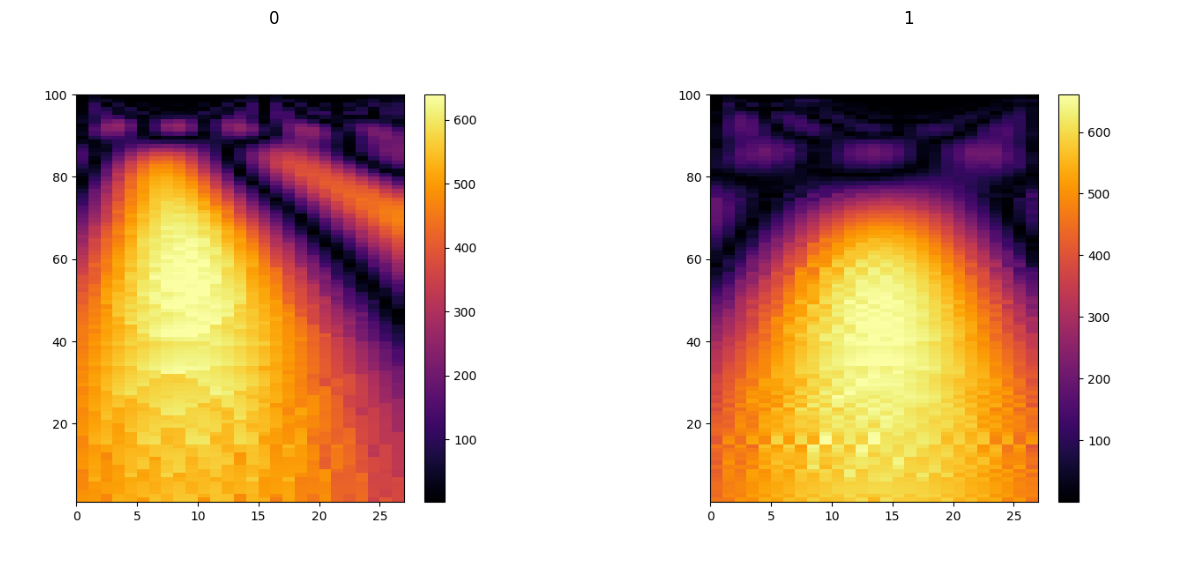

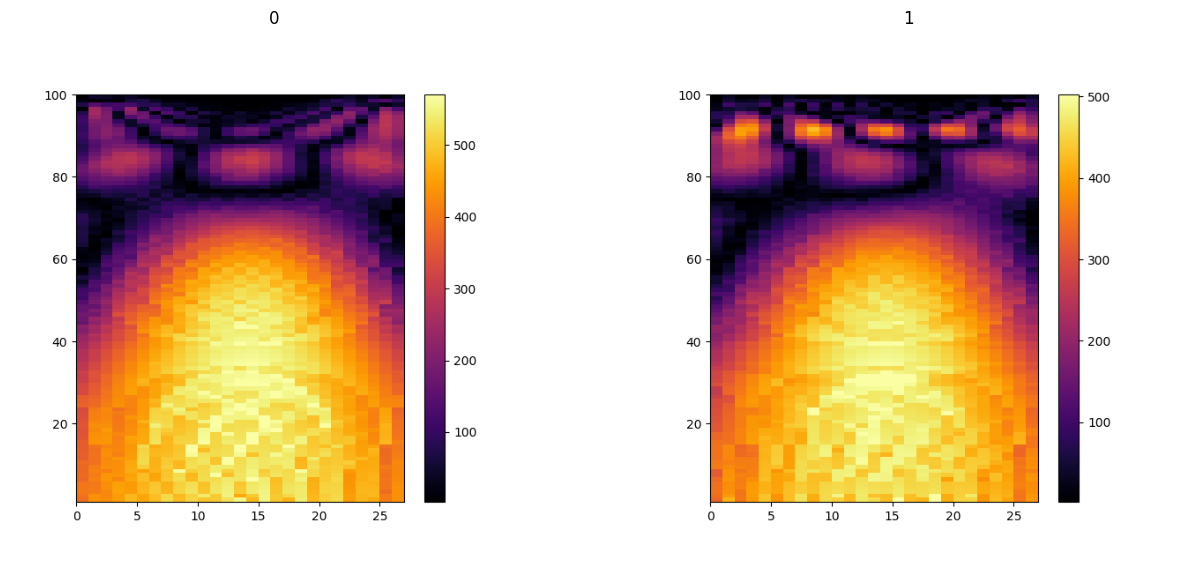

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([2977, 3, 227, 227]) cpu
y_train: torch.Size([2977]) cpu
X_test: torch.Size([743, 3, 227, 227]) cpu
y_test: torch.Size([743]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [ ]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [ ]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 2
batch_size = 32
num_epochs = 100
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/anomalias-v1/representacion_3/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/2


Fold 1 | Epoch 1/100: 100%|██████████| 47/47 [00:25<00:00,  1.81it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 88.78% - Train Loss: 0.6507 | Val Acc: 93.15% - Val Loss: 0.5209


Fold 1 | Epoch 2/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 98.72% - Train Loss: 0.4981 | Val Acc: 93.49% - Val Loss: 0.4512


Fold 1 | Epoch 3/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 94.42% - Train Loss: 0.4309 | Val Acc: 99.40% - Val Loss: 0.3807


Fold 1 | Epoch 4/100: 100%|██████████| 47/47 [00:16<00:00,  2.78it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 96.37% - Train Loss: 0.5460 | Val Acc: 98.46% - Val Loss: 0.3701


Fold 1 | Epoch 5/100: 100%|██████████| 47/47 [00:18<00:00,  2.57it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 93.15% - Train Loss: 0.4831 | Val Acc: 99.19% - Val Loss: 0.3695


Fold 1 | Epoch 6/100: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 91.33% - Train Loss: 0.5128 | Val Acc: 88.31% - Val Loss: 0.4303


Fold 1 | Epoch 7/100: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 90.93% - Train Loss: 0.4886 | Val Acc: 92.08% - Val Loss: 0.4013


Fold 1 | Epoch 8/100: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 93.75% - Train Loss: 0.5137 | Val Acc: 81.80% - Val Loss: 0.5023


Fold 1 | Epoch 9/100: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 89.92% - Train Loss: 0.4688 | Val Acc: 94.56% - Val Loss: 0.3843


Fold 1 | Epoch 10/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 93.82% - Train Loss: 0.5138 | Val Acc: 83.48% - Val Loss: 0.4874


Fold 1 | Epoch 11/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 86.16% - Train Loss: 0.5338 | Val Acc: 84.28% - Val Loss: 0.4695


Fold 1 | Epoch 12/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 93.88% - Train Loss: 0.4503 | Val Acc: 85.02% - Val Loss: 0.4568


Fold 1 | Epoch 13/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 91.80% - Train Loss: 0.4382 | Val Acc: 91.54% - Val Loss: 0.4053


Fold 1 | Epoch 14/100: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 93.95% - Train Loss: 0.4756 | Val Acc: 72.13% - Val Loss: 0.5904


Fold 1 | Epoch 15/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 87.50% - Train Loss: 0.5159 | Val Acc: 97.65% - Val Loss: 0.3769


Fold 1 | Epoch 16/100: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 93.01% - Train Loss: 0.4684 | Val Acc: 86.57% - Val Loss: 0.4419


Fold 1 | Epoch 17/100: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 88.64% - Train Loss: 0.5215 | Val Acc: 98.72% - Val Loss: 0.3798


Fold 1 | Epoch 18/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 93.35% - Train Loss: 0.5371 | Val Acc: 93.96% - Val Loss: 0.3906


Fold 1 | Epoch 19/100: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 90.66% - Train Loss: 0.4446 | Val Acc: 94.09% - Val Loss: 0.3900


Fold 1 | Epoch 20/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 92.14% - Train Loss: 0.4740 | Val Acc: 93.75% - Val Loss: 0.3931


Fold 1 | Epoch 21/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 90.73% - Train Loss: 0.5171 | Val Acc: 95.50% - Val Loss: 0.3834


Fold 1 | Epoch 22/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 92.27% - Train Loss: 0.4468 | Val Acc: 94.63% - Val Loss: 0.3914


Fold 1 | Epoch 23/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 90.32% - Train Loss: 0.4792 | Val Acc: 96.17% - Val Loss: 0.3855


Fold 1 | Epoch 24/100: 100%|██████████| 47/47 [00:13<00:00,  3.45it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 93.28% - Train Loss: 0.4386 | Val Acc: 88.85% - Val Loss: 0.4248


Fold 1 | Epoch 25/100: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 94.89% - Train Loss: 0.4324 | Val Acc: 84.02% - Val Loss: 0.4802


Fold 1 | Epoch 26/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 93.55% - Train Loss: 0.4220 | Val Acc: 86.17% - Val Loss: 0.4491


Fold 1 | Epoch 27/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 93.08% - Train Loss: 0.4440 | Val Acc: 84.62% - Val Loss: 0.4779


Fold 1 | Epoch 28/100: 100%|██████████| 47/47 [00:13<00:00,  3.45it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 95.03% - Train Loss: 0.4934 | Val Acc: 84.15% - Val Loss: 0.4855


Fold 1 | Epoch 29/100: 100%|██████████| 47/47 [00:13<00:00,  3.43it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 83.53% - Train Loss: 0.5181 | Val Acc: 65.28% - Val Loss: 0.5841


Fold 1 | Epoch 30/100: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 89.58% - Train Loss: 0.4918 | Val Acc: 88.31% - Val Loss: 0.4332


Fold 1 | Epoch 31/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 93.35% - Train Loss: 0.4382 | Val Acc: 84.15% - Val Loss: 0.4862


Fold 1 | Epoch 32/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 89.92% - Train Loss: 0.4770 | Val Acc: 96.71% - Val Loss: 0.3860


Fold 1 | Epoch 33/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 93.08% - Train Loss: 0.4985 | Val Acc: 87.58% - Val Loss: 0.4349


Fold 1 | Epoch 34/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 90.46% - Train Loss: 0.4633 | Val Acc: 77.90% - Val Loss: 0.5617


Fold 1 | Epoch 35/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 91.87% - Train Loss: 0.4290 | Val Acc: 92.95% - Val Loss: 0.4024


Fold 1 | Epoch 36/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 90.52% - Train Loss: 0.4557 | Val Acc: 94.63% - Val Loss: 0.3912


Fold 1 | Epoch 37/100: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 93.15% - Train Loss: 0.3967 | Val Acc: 85.96% - Val Loss: 0.4553


Fold 1 | Epoch 38/100: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 89.58% - Train Loss: 0.4478 | Val Acc: 96.84% - Val Loss: 0.3905


Fold 1 | Epoch 39/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 90.99% - Train Loss: 0.4448 | Val Acc: 94.22% - Val Loss: 0.3978


Fold 1 | Epoch 40/100: 100%|██████████| 47/47 [00:13<00:00,  3.39it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 93.41% - Train Loss: 0.4117 | Val Acc: 84.35% - Val Loss: 0.4731


Fold 1 | Epoch 41/100: 100%|██████████| 47/47 [00:13<00:00,  3.46it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 94.69% - Train Loss: 0.3974 | Val Acc: 73.00% - Val Loss: 0.6163


Fold 1 | Epoch 42/100: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 87.84% - Train Loss: 0.4397 | Val Acc: 92.55% - Val Loss: 0.4071


Fold 1 | Epoch 43/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 92.67% - Train Loss: 0.4426 | Val Acc: 86.97% - Val Loss: 0.4424


Fold 1 | Epoch 44/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 90.66% - Train Loss: 0.3748 | Val Acc: 97.52% - Val Loss: 0.4014


Fold 1 | Epoch 45/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 95.16% - Train Loss: 0.3661 | Val Acc: 91.00% - Val Loss: 0.4173


Fold 1 | Epoch 46/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 89.99% - Train Loss: 0.4245 | Val Acc: 95.70% - Val Loss: 0.3956


Fold 1 | Epoch 47/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 92.81% - Train Loss: 0.4074 | Val Acc: 98.05% - Val Loss: 0.4070


Fold 1 | Epoch 48/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 90.93% - Train Loss: 0.4187 | Val Acc: 68.91% - Val Loss: 0.6213


Fold 1 | Epoch 49/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 89.45% - Train Loss: 0.4175 | Val Acc: 90.80% - Val Loss: 0.4180


Fold 1 | Epoch 50/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 91.47% - Train Loss: 0.4422 | Val Acc: 83.68% - Val Loss: 0.4871


Fold 1 | Epoch 51/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 92.54% - Train Loss: 0.4071 | Val Acc: 90.40% - Val Loss: 0.4165


Fold 1 | Epoch 52/100: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 93.68% - Train Loss: 0.4188 | Val Acc: 88.45% - Val Loss: 0.4286


Fold 1 | Epoch 53/100: 100%|██████████| 47/47 [00:13<00:00,  3.47it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 91.33% - Train Loss: 0.4406 | Val Acc: 86.03% - Val Loss: 0.4578


Fold 1 | Epoch 54/100: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 90.52% - Train Loss: 0.4434 | Val Acc: 92.48% - Val Loss: 0.4116


Fold 1 | Epoch 55/100: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 91.67% - Train Loss: 0.4041 | Val Acc: 83.61% - Val Loss: 0.4910


Fold 1 | Epoch 56/100: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 92.88% - Train Loss: 0.4153 | Val Acc: 85.22% - Val Loss: 0.4716


Fold 1 | Epoch 57/100: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 91.47% - Train Loss: 0.4054 | Val Acc: 90.33% - Val Loss: 0.4249


Fold 1 | Epoch 58/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 92.54% - Train Loss: 0.3824 | Val Acc: 86.50% - Val Loss: 0.4569


Fold 1 | Epoch 59/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 90.86% - Train Loss: 0.3977 | Val Acc: 99.33% - Val Loss: 0.4676


Fold 1 | Epoch 60/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 94.35% - Train Loss: 0.4321 | Val Acc: 85.09% - Val Loss: 0.4769


Fold 1 | Epoch 61/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 93.68% - Train Loss: 0.4023 | Val Acc: 87.51% - Val Loss: 0.4454


Fold 1 | Epoch 62/100: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 89.99% - Train Loss: 0.4200 | Val Acc: 95.50% - Val Loss: 0.4008


Fold 1 | Epoch 63/100: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 91.13% - Train Loss: 0.4539 | Val Acc: 93.55% - Val Loss: 0.4060


Fold 1 | Epoch 64/100: 100%|██████████| 47/47 [00:14<00:00,  3.31it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 92.00% - Train Loss: 0.4435 | Val Acc: 97.18% - Val Loss: 0.4003


Fold 1 | Epoch 65/100: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 90.99% - Train Loss: 0.4433 | Val Acc: 98.05% - Val Loss: 0.4127


Fold 1 | Epoch 66/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 88.98% - Train Loss: 0.3986 | Val Acc: 88.78% - Val Loss: 0.4346


Fold 1 | Epoch 67/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 92.41% - Train Loss: 0.4148 | Val Acc: 83.75% - Val Loss: 0.4957


Fold 1 | Epoch 68/100: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 88.91% - Train Loss: 0.4276 | Val Acc: 95.37% - Val Loss: 0.4022


Fold 1 | Epoch 69/100: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 89.38% - Train Loss: 0.4551 | Val Acc: 83.75% - Val Loss: 0.4885


Fold 1 | Epoch 70/100: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 92.41% - Train Loss: 0.3991 | Val Acc: 86.37% - Val Loss: 0.4523


Fold 1 | Epoch 71/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 92.54% - Train Loss: 0.4217 | Val Acc: 97.31% - Val Loss: 0.3968


Fold 1 | Epoch 72/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 92.88% - Train Loss: 0.3923 | Val Acc: 88.31% - Val Loss: 0.4370


Fold 1 | Epoch 73/100: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 92.07% - Train Loss: 0.4457 | Val Acc: 83.88% - Val Loss: 0.4821


Fold 1 | Epoch 74/100: 100%|██████████| 47/47 [00:13<00:00,  3.48it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 90.86% - Train Loss: 0.3996 | Val Acc: 83.81% - Val Loss: 0.4856


Fold 1 | Epoch 75/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 93.48% - Train Loss: 0.3766 | Val Acc: 93.08% - Val Loss: 0.4081


Fold 1 | Epoch 76/100: 100%|██████████| 47/47 [00:13<00:00,  3.39it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 92.47% - Train Loss: 0.3984 | Val Acc: 90.73% - Val Loss: 0.4200


Fold 1 | Epoch 77/100: 100%|██████████| 47/47 [00:13<00:00,  3.48it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 91.47% - Train Loss: 0.3728 | Val Acc: 95.57% - Val Loss: 0.3998


Fold 1 | Epoch 78/100: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 94.15% - Train Loss: 0.3754 | Val Acc: 97.04% - Val Loss: 0.4024


Fold 1 | Epoch 79/100: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 86.63% - Train Loss: 0.4721 | Val Acc: 87.71% - Val Loss: 0.4454


Fold 1 | Epoch 80/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 93.75% - Train Loss: 0.4590 | Val Acc: 64.20% - Val Loss: 0.6460


Fold 1 | Epoch 81/100: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 91.06% - Train Loss: 0.3975 | Val Acc: 84.75% - Val Loss: 0.4731


Fold 1 | Epoch 82/100: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 92.54% - Train Loss: 0.3538 | Val Acc: 93.02% - Val Loss: 0.4127


Fold 1 | Epoch 83/100: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 92.47% - Train Loss: 0.3895 | Val Acc: 87.31% - Val Loss: 0.4502


Fold 1 | Epoch 84/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 91.33% - Train Loss: 0.3833 | Val Acc: 94.69% - Val Loss: 0.4085


Fold 1 | Epoch 85/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 90.93% - Train Loss: 0.3790 | Val Acc: 94.69% - Val Loss: 0.4117


Fold 1 | Epoch 86/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 95.83% - Train Loss: 0.3547 | Val Acc: 84.22% - Val Loss: 0.4723


Fold 1 | Epoch 87/100: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 89.38% - Train Loss: 0.4412 | Val Acc: 89.25% - Val Loss: 0.4322


Fold 1 | Epoch 88/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 92.94% - Train Loss: 0.3722 | Val Acc: 90.80% - Val Loss: 0.4239


Fold 1 | Epoch 89/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 90.32% - Train Loss: 0.3992 | Val Acc: 94.22% - Val Loss: 0.4079


Fold 1 | Epoch 90/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 93.08% - Train Loss: 0.4509 | Val Acc: 84.42% - Val Loss: 0.4721


Fold 1 | Epoch 91/100: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 89.85% - Train Loss: 0.3887 | Val Acc: 86.64% - Val Loss: 0.4549


Fold 1 | Epoch 92/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 92.20% - Train Loss: 0.3563 | Val Acc: 94.16% - Val Loss: 0.4138


Fold 1 | Epoch 93/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 91.20% - Train Loss: 0.4297 | Val Acc: 88.99% - Val Loss: 0.4409


Fold 1 | Epoch 94/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 92.81% - Train Loss: 0.3567 | Val Acc: 85.76% - Val Loss: 0.4671


Fold 1 | Epoch 95/100: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 92.54% - Train Loss: 0.4133 | Val Acc: 98.32% - Val Loss: 0.4108


Fold 1 | Epoch 96/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 89.11% - Train Loss: 0.4444 | Val Acc: 91.20% - Val Loss: 0.4192


Fold 1 | Epoch 97/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 93.41% - Train Loss: 0.3512 | Val Acc: 90.19% - Val Loss: 0.4246


Fold 1 | Epoch 98/100: 100%|██████████| 47/47 [00:13<00:00,  3.46it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 94.89% - Train Loss: 0.3072 | Val Acc: 94.83% - Val Loss: 0.4081


Fold 1 | Epoch 99/100: 100%|██████████| 47/47 [00:13<00:00,  3.50it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 90.99% - Train Loss: 0.3571 | Val Acc: 98.79% - Val Loss: 0.4130


Fold 1 | Epoch 100/100: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 95.03% - Train Loss: 0.3814 | Val Acc: 88.31% - Val Loss: 0.4442

📂 Fold 2/2


Fold 2 | Epoch 1/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 99.46% - Train Loss: 0.4711 | Val Acc: 98.86% - Val Loss: 0.5070


Fold 2 | Epoch 2/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 99.40% - Train Loss: 0.3786 | Val Acc: 98.86% - Val Loss: 0.7551


Fold 2 | Epoch 3/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 99.40% - Train Loss: 0.4243 | Val Acc: 98.79% - Val Loss: 0.4741


Fold 2 | Epoch 4/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 99.46% - Train Loss: 0.3627 | Val Acc: 98.59% - Val Loss: 0.4579


Fold 2 | Epoch 5/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 99.33% - Train Loss: 0.3641 | Val Acc: 98.19% - Val Loss: 0.4578


Fold 2 | Epoch 6/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 98.19% - Train Loss: 0.3713 | Val Acc: 98.05% - Val Loss: 0.4550


Fold 2 | Epoch 7/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 99.40% - Train Loss: 0.3740 | Val Acc: 93.08% - Val Loss: 0.4859


Fold 2 | Epoch 8/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 96.78% - Train Loss: 0.4075 | Val Acc: 97.24% - Val Loss: 0.4654


Fold 2 | Epoch 9/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 98.66% - Train Loss: 0.3260 | Val Acc: 98.32% - Val Loss: 0.4798


Fold 2 | Epoch 10/100: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 99.13% - Train Loss: 0.3237 | Val Acc: 98.12% - Val Loss: 0.4807


Fold 2 | Epoch 11/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 99.13% - Train Loss: 0.3241 | Val Acc: 97.98% - Val Loss: 0.4779


Fold 2 | Epoch 12/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 99.06% - Train Loss: 0.3189 | Val Acc: 98.79% - Val Loss: 0.5734


Fold 2 | Epoch 13/100: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 98.59% - Train Loss: 0.2997 | Val Acc: 98.79% - Val Loss: 0.5602


Fold 2 | Epoch 14/100: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 98.99% - Train Loss: 0.3218 | Val Acc: 98.79% - Val Loss: 0.5910


Fold 2 | Epoch 15/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 98.59% - Train Loss: 0.2945 | Val Acc: 98.79% - Val Loss: 0.6864


Fold 2 | Epoch 16/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 98.66% - Train Loss: 0.3929 | Val Acc: 98.79% - Val Loss: 0.6321


Fold 2 | Epoch 17/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 98.66% - Train Loss: 0.2893 | Val Acc: 98.45% - Val Loss: 0.5429


Fold 2 | Epoch 18/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 99.26% - Train Loss: 0.2716 | Val Acc: 98.25% - Val Loss: 0.5193


Fold 2 | Epoch 19/100: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 99.13% - Train Loss: 0.2820 | Val Acc: 98.45% - Val Loss: 0.5391


Fold 2 | Epoch 20/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 99.13% - Train Loss: 0.3367 | Val Acc: 97.98% - Val Loss: 0.4759


Fold 2 | Epoch 21/100: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 91.34% - Train Loss: 0.3252 | Val Acc: 98.79% - Val Loss: 0.7060


Fold 2 | Epoch 22/100: 100%|██████████| 47/47 [00:13<00:00,  3.43it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 98.66% - Train Loss: 0.2675 | Val Acc: 98.52% - Val Loss: 0.6109


Fold 2 | Epoch 23/100: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 98.52% - Train Loss: 0.2830 | Val Acc: 98.72% - Val Loss: 0.6576


Fold 2 | Epoch 24/100: 100%|██████████| 47/47 [00:13<00:00,  3.45it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 95.77% - Train Loss: 0.2872 | Val Acc: 98.66% - Val Loss: 0.6575


Fold 2 | Epoch 25/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 98.79% - Train Loss: 0.3071 | Val Acc: 98.39% - Val Loss: 0.5669


Fold 2 | Epoch 26/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 98.72% - Train Loss: 0.2637 | Val Acc: 98.25% - Val Loss: 0.5614


Fold 2 | Epoch 27/100: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 98.59% - Train Loss: 0.2597 | Val Acc: 98.66% - Val Loss: 0.6981


Fold 2 | Epoch 28/100: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 98.66% - Train Loss: 0.2299 | Val Acc: 98.79% - Val Loss: 0.7954


Fold 2 | Epoch 29/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 98.32% - Train Loss: 0.2786 | Val Acc: 98.25% - Val Loss: 0.5763


Fold 2 | Epoch 30/100: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 98.86% - Train Loss: 0.2494 | Val Acc: 98.12% - Val Loss: 0.5419


Fold 2 | Epoch 31/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 97.38% - Train Loss: 0.3733 | Val Acc: 98.45% - Val Loss: 0.6095


Fold 2 | Epoch 32/100: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 98.25% - Train Loss: 0.3018 | Val Acc: 90.46% - Val Loss: 0.4922


Fold 2 | Epoch 33/100: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 97.92% - Train Loss: 0.2260 | Val Acc: 98.52% - Val Loss: 0.6397


Fold 2 | Epoch 34/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 99.06% - Train Loss: 0.2324 | Val Acc: 98.39% - Val Loss: 0.6200


Fold 2 | Epoch 35/100: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 98.25% - Train Loss: 0.2598 | Val Acc: 98.52% - Val Loss: 0.6409


Fold 2 | Epoch 36/100: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 98.72% - Train Loss: 0.2666 | Val Acc: 97.72% - Val Loss: 0.5166


Fold 2 | Epoch 37/100: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 98.39% - Train Loss: 0.2541 | Val Acc: 98.52% - Val Loss: 0.6521


Fold 2 | Epoch 38/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 98.39% - Train Loss: 0.2542 | Val Acc: 98.25% - Val Loss: 0.5825


Fold 2 | Epoch 39/100: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 97.85% - Train Loss: 0.2328 | Val Acc: 98.72% - Val Loss: 0.8090


Fold 2 | Epoch 40/100: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 98.72% - Train Loss: 0.3068 | Val Acc: 97.92% - Val Loss: 0.5427


Fold 2 | Epoch 41/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 98.99% - Train Loss: 0.2280 | Val Acc: 96.30% - Val Loss: 0.4869


Fold 2 | Epoch 42/100: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 97.11% - Train Loss: 0.2553 | Val Acc: 98.59% - Val Loss: 0.7176


Fold 2 | Epoch 43/100: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 98.66% - Train Loss: 0.2389 | Val Acc: 98.25% - Val Loss: 0.6092


Fold 2 | Epoch 44/100: 100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 96.57% - Train Loss: 0.2847 | Val Acc: 98.39% - Val Loss: 0.6833


Fold 2 | Epoch 45/100: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 98.59% - Train Loss: 0.2438 | Val Acc: 98.05% - Val Loss: 0.5936


Fold 2 | Epoch 46/100: 100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 97.45% - Train Loss: 0.2627 | Val Acc: 98.25% - Val Loss: 0.6020


Fold 2 | Epoch 47/100: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 98.93% - Train Loss: 0.2523 | Val Acc: 97.72% - Val Loss: 0.5522


Fold 2 | Epoch 48/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 98.25% - Train Loss: 0.2333 | Val Acc: 97.72% - Val Loss: 0.5421


Fold 2 | Epoch 49/100: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 98.05% - Train Loss: 0.2166 | Val Acc: 98.45% - Val Loss: 0.7262


Fold 2 | Epoch 50/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 98.12% - Train Loss: 0.2436 | Val Acc: 97.85% - Val Loss: 0.5588


Fold 2 | Epoch 51/100: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 96.44% - Train Loss: 0.2919 | Val Acc: 98.25% - Val Loss: 0.6038


Fold 2 | Epoch 52/100: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 98.66% - Train Loss: 0.2172 | Val Acc: 98.32% - Val Loss: 0.6278


Fold 2 | Epoch 53/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 98.72% - Train Loss: 0.2232 | Val Acc: 98.32% - Val Loss: 0.6550


Fold 2 | Epoch 54/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 98.86% - Train Loss: 0.1948 | Val Acc: 98.32% - Val Loss: 0.6579


Fold 2 | Epoch 55/100: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 98.32% - Train Loss: 0.2238 | Val Acc: 96.17% - Val Loss: 0.5465


Fold 2 | Epoch 56/100: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 97.52% - Train Loss: 0.2413 | Val Acc: 98.25% - Val Loss: 0.6076


Fold 2 | Epoch 57/100: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 98.99% - Train Loss: 0.2268 | Val Acc: 98.12% - Val Loss: 0.5991


Fold 2 | Epoch 58/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 97.38% - Train Loss: 0.2470 | Val Acc: 97.65% - Val Loss: 0.5583


Fold 2 | Epoch 59/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 98.52% - Train Loss: 0.1855 | Val Acc: 98.59% - Val Loss: 0.7599


Fold 2 | Epoch 60/100: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 96.84% - Train Loss: 0.2419 | Val Acc: 98.45% - Val Loss: 0.7343


Fold 2 | Epoch 61/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 98.72% - Train Loss: 0.3192 | Val Acc: 97.45% - Val Loss: 0.5580


Fold 2 | Epoch 62/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 97.58% - Train Loss: 0.2371 | Val Acc: 97.58% - Val Loss: 0.5722


Fold 2 | Epoch 63/100: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 96.64% - Train Loss: 0.2503 | Val Acc: 97.98% - Val Loss: 0.6235


Fold 2 | Epoch 64/100: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 98.32% - Train Loss: 0.2188 | Val Acc: 97.92% - Val Loss: 0.6172


Fold 2 | Epoch 65/100: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 97.99% - Train Loss: 0.2217 | Val Acc: 98.39% - Val Loss: 0.7345


Fold 2 | Epoch 66/100: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 98.52% - Train Loss: 0.2253 | Val Acc: 98.32% - Val Loss: 0.6843


Fold 2 | Epoch 67/100: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 98.79% - Train Loss: 0.2087 | Val Acc: 98.19% - Val Loss: 0.6466


Fold 2 | Epoch 68/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 98.32% - Train Loss: 0.1987 | Val Acc: 98.32% - Val Loss: 0.6731


Fold 2 | Epoch 69/100: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 97.92% - Train Loss: 0.2182 | Val Acc: 94.89% - Val Loss: 0.5436


Fold 2 | Epoch 70/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 94.63% - Train Loss: 0.2851 | Val Acc: 97.72% - Val Loss: 0.5949


Fold 2 | Epoch 71/100: 100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 97.31% - Train Loss: 0.1798 | Val Acc: 98.72% - Val Loss: 0.9560


Fold 2 | Epoch 72/100: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 98.39% - Train Loss: 0.2236 | Val Acc: 98.45% - Val Loss: 0.7890


Fold 2 | Epoch 73/100: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 95.77% - Train Loss: 0.2780 | Val Acc: 97.92% - Val Loss: 0.6335


Fold 2 | Epoch 74/100: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 97.78% - Train Loss: 0.2263 | Val Acc: 97.78% - Val Loss: 0.6083


Fold 2 | Epoch 75/100: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 98.05% - Train Loss: 0.1545 | Val Acc: 98.52% - Val Loss: 0.8529


Fold 2 | Epoch 76/100: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 98.59% - Train Loss: 0.2063 | Val Acc: 91.13% - Val Loss: 0.5583


Fold 2 | Epoch 77/100: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 96.51% - Train Loss: 0.2234 | Val Acc: 97.31% - Val Loss: 0.6094


Fold 2 | Epoch 78/100: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 97.99% - Train Loss: 0.1918 | Val Acc: 98.25% - Val Loss: 0.7025


Fold 2 | Epoch 79/100: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 98.32% - Train Loss: 0.2147 | Val Acc: 98.32% - Val Loss: 0.7327


Fold 2 | Epoch 80/100: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 98.19% - Train Loss: 0.2794 | Val Acc: 92.54% - Val Loss: 0.5879


Fold 2 | Epoch 81/100: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 97.25% - Train Loss: 0.2225 | Val Acc: 96.24% - Val Loss: 0.6088


Fold 2 | Epoch 82/100: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 98.52% - Train Loss: 0.2236 | Val Acc: 96.98% - Val Loss: 0.6200


Fold 2 | Epoch 83/100: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 97.31% - Train Loss: 0.2142 | Val Acc: 98.12% - Val Loss: 0.6784


Fold 2 | Epoch 84/100: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 98.32% - Train Loss: 0.2456 | Val Acc: 98.32% - Val Loss: 0.7474


Fold 2 | Epoch 85/100: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 96.31% - Train Loss: 0.2362 | Val Acc: 98.32% - Val Loss: 0.7551


Fold 2 | Epoch 86/100: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 97.92% - Train Loss: 0.2069 | Val Acc: 98.19% - Val Loss: 0.7101


Fold 2 | Epoch 87/100: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 99.33% - Train Loss: 0.1972 | Val Acc: 97.98% - Val Loss: 0.6733


Fold 2 | Epoch 88/100: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 95.90% - Train Loss: 0.1845 | Val Acc: 98.39% - Val Loss: 0.7884


Fold 2 | Epoch 89/100: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 98.32% - Train Loss: 0.1966 | Val Acc: 97.92% - Val Loss: 0.6663


Fold 2 | Epoch 90/100: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 96.17% - Train Loss: 0.2604 | Val Acc: 98.32% - Val Loss: 0.7605


Fold 2 | Epoch 91/100: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 97.25% - Train Loss: 0.2325 | Val Acc: 98.32% - Val Loss: 0.7556


Fold 2 | Epoch 92/100: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 98.39% - Train Loss: 0.2206 | Val Acc: 95.50% - Val Loss: 0.5920


Fold 2 | Epoch 93/100: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 97.31% - Train Loss: 0.1909 | Val Acc: 98.32% - Val Loss: 0.7222


Fold 2 | Epoch 94/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 99.06% - Train Loss: 0.1954 | Val Acc: 97.78% - Val Loss: 0.6743


Fold 2 | Epoch 95/100: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 95.16% - Train Loss: 0.2238 | Val Acc: 97.51% - Val Loss: 0.6462


Fold 2 | Epoch 96/100: 100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 97.92% - Train Loss: 0.1796 | Val Acc: 97.78% - Val Loss: 0.6780


Fold 2 | Epoch 97/100: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 97.92% - Train Loss: 0.2163 | Val Acc: 98.32% - Val Loss: 0.7510


Fold 2 | Epoch 98/100: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 96.51% - Train Loss: 0.2404 | Val Acc: 98.19% - Val Loss: 0.7341


Fold 2 | Epoch 99/100: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 96.98% - Train Loss: 0.1761 | Val Acc: 98.59% - Val Loss: 0.9068


Fold 2 | Epoch 100/100: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 96.31% - Train Loss: 0.2412 | Val Acc: 98.32% - Val Loss: 0.7802

RESULTADOS:
-> Mean Train Accuracy: 95.6666%
-> Mean Train Loss: 0.3113
-> Mean Validation Accuracy: 93.3171%
-> Mean Validation Loss: 0.6122


***Graficar los resultados del entrenamiento :***

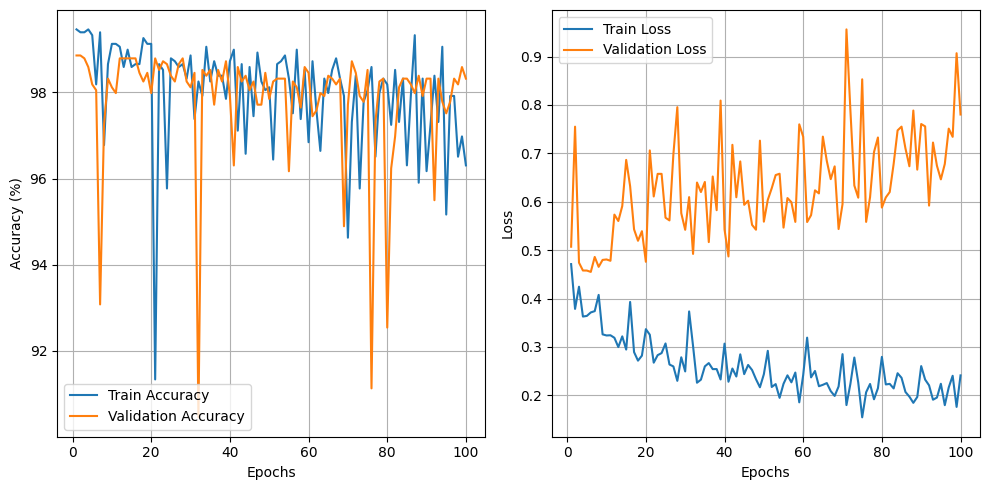

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/anomalias-v1/representacion_3/longitud_28/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/anomalias-v1/representacion_3/longitud_28/ConvNext_Tiny_fold_2.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []
all_probs = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        #_, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:,1]
        predicted = torch.argmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

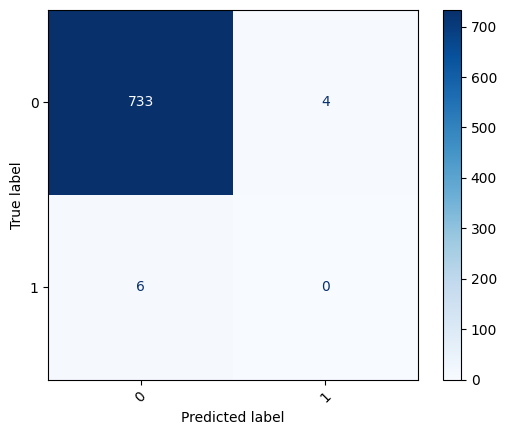

In [12]:
#class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
class_names = ['0', '1']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

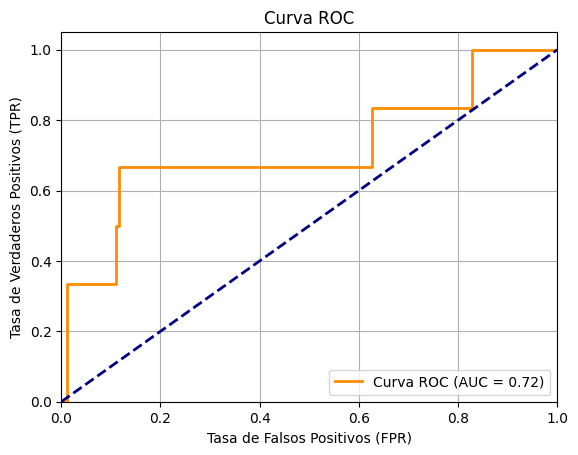

AUC: 0.7157


In [13]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 🔢 AUC como número
print(f"AUC: {roc_auc_score(all_labels, all_probs):.4f}")

***Análisis de los resultados obtenidos :***

In [14]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/anomalias-v1/representacion_3/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       737
           1       0.00      0.00      0.00         6

    accuracy                           0.99       743
   macro avg       0.50      0.50      0.50       743
weighted avg       0.98      0.99      0.99       743

